In [3]:
## Onetime run to unzip the images
#!unzip Dataset/img_align_celeba.zip -d Dataset/Raw > /dev/null

In [1]:
#Importing the needed packages
import numpy as np
import matplotlib.pyplot as plt
import skimage
from PIL import Image
from skimage import data, io, filters, color, exposure
from skimage.transform import rotate
import pandas as pd
import cv2
import glob
import time

%matplotlib inline

# Data cleansing

Below are the steps for data cleansing:

1. 50000 images are chosen for model training.
2. Extracting all images' pixel values to make features dataset
3. Extracting all images' labels to make labels

In [2]:
# Step 1 and 2
## Appending all images as an array
list_of_images = []
start_val = 1
stop_val = 50000

## Directory value may need to be changed
dir_val = 'img_align_celeba/'

start = time.time()
for i in range(start_val,(stop_val + 1)): 
    curr_pic = str(i)
    curr_pic = ''.join(['0' for x in range(6-len(curr_pic))]) + curr_pic
    curr_pic = dir_val + curr_pic + ".jpg"
    training_set = np.array(Image.open(curr_pic))
    list_of_images.append(training_set)

    if(i%5000==0):
      print('Curr iteration is ' + str(i))

stop = time.time()

dataset = np.array(list_of_images)
print("The size of dataset: ", dataset.shape)
#del list_of_images

Curr iteration is 5000
Curr iteration is 10000
Curr iteration is 15000
Curr iteration is 20000
Curr iteration is 25000
Curr iteration is 30000
Curr iteration is 35000
Curr iteration is 40000
Curr iteration is 45000
Curr iteration is 50000
The size of dataset:  (50000, 218, 178, 3)


In [3]:
# Step 3
## The attribute csv with all features
attributes_path = "list_attr_celeba.csv"
attribute_df = pd.read_csv(attributes_path)
attribute_df = attribute_df.loc[:(stop_val -1 )]

#This will need to be changed with respect to attribute to train for
classification_attribute = "Oval_Face"

labels = np.where(attribute_df[classification_attribute]==1,1,0)
print("The size of labels: ", labels.shape)

The size of labels:  (50000,)


# Train-Test Split

In [4]:
## Choosing the first 30000 as the training set and the rest 20000 as the test set
x_train = dataset[:30000,:,:,:]
x_test = dataset[30000:,:,:,:]
del dataset

In [5]:
y_train = labels[:30000]
y_test = labels[30000:]
del labels

# Checking data and labels

Label of 1 indicates that the attribute is present while 0 means it is absent.

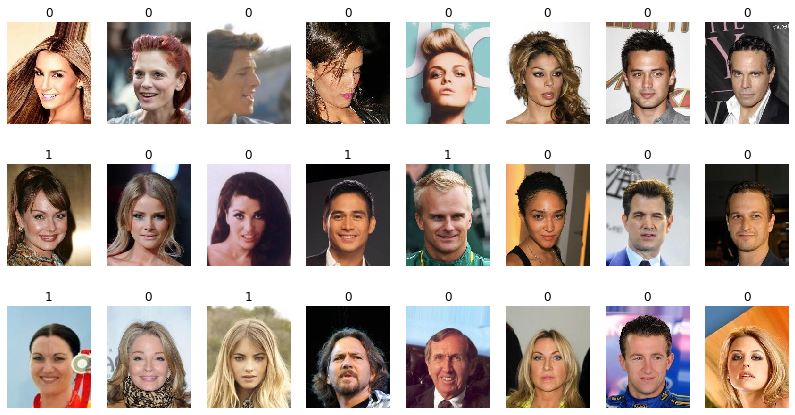

In [6]:
# Display the first few  training images
images_and_labels = list(zip(x_train[:24], y_train[:24]))
plt.figure(figsize=(14,10))
for index, (image, label) in enumerate(images_and_labels):
    plt.subplot(4, 8, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = str(label)
    plt.title(index)
plt.show()

# Modeling

In the modeling section, we will build a custom model, a transfer learning model and use a pre-trained model to check what can be detected on a few images.

In [7]:
#import tensorflow.keras as keras
#from tensorflow.keras import layers
import tensorflow
import tensorflow_addons as tfa
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential,load_model, Model 
from tensorflow.keras.optimizers import SGD, Adadelta
#from keras.utils import np_utils
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG19
from keras import applications

2023-05-28 16:17:15.041559: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-28 16:17:15.087443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 16:17:16.906743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/nfs/home/ayo7379/.local/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode unti

In [8]:
# Setting common model parameters and hyperparameters
input_shape = (218,178,3)
num_classes = 1
epochs = 100
batch_size=16

In [9]:
my_callbacks = [EarlyStopping(monitor = "val_loss", patience=3,\
                  verbose=1, min_delta=0.001)]

## Model 1 - Custom Model

### Model Architecture Summary
The model architecture you provided is a convolutional neural network (CNN) commonly used for image classification tasks. Here is a breakdown of the different layers and their functions:

1. Conv2D layer with 32 filters and a kernel size of (3, 3): This layer performs convolutional operations on the input images, extracting local features using the 32 filters. The activation function used is ReLU (Rectified Linear Unit), which introduces non-linearity to the model.

2. BatchNormalization layer: This layer normalizes the activations of the previous layer, helping to stabilize and speed up the training process.

3. Conv2D layer with 64 filters and a kernel size of (3, 3): Similar to the first Conv2D layer, this layer performs convolutional operations on the previous layer's output, extracting additional features.

4. MaxPooling2D layer with a pool size of (2, 2): This layer reduces the spatial dimensions of the input by performing a downsampling operation, taking the maximum value within each 2x2 window. It helps to reduce the computational complexity and extract dominant features.

5. Dropout layer with a rate of 0.25: Dropout is a regularization technique that randomly sets a fraction of input units to 0 at each update during training. It helps prevent overfitting by introducing noise and forcing the network to learn more robust features.

6. Flatten layer: This layer flattens the previous layer's output into a 1-dimensional vector. It prepares the data for the fully connected layers that follow.

7. Dense layer with 128 units and ReLU activation: This fully connected layer connects every neuron from the previous layer to the current layer. It applies a linear transformation to the input data and applies the ReLU activation function.

8. Dropout layer with a rate of 0.5: Another dropout layer is added after the first fully connected layer to further regularize the model.

9. Dense layer with 1 unit and sigmoid activation: This final dense layer is responsible for the binary classification task (1 or 0). The sigmoid activation function squashes the output into the range of [0, 1], representing the probability of the input belonging to the positive class.

In summary, this model consists of convolutional layers to extract features from input images, pooling layers to downsample the spatial dimensions, fully connected layers for classification, and dropout layers for regularization.

### Training and saving model

In [10]:
def base_model_1(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
   
    return model

In [11]:
## Building the first model
model_custom = base_model_1(input_shape)
model_custom.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 216, 176, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 216, 176, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 214, 174, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 107, 87, 64)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 107, 87, 64)       0         
                                                                 
 flatten (Flatten)           (None, 595776)            0

2023-05-28 16:17:24.161211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46671 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-05-28 16:17:24.162093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46671 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-05-28 16:17:24.162753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46671 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:88:00.0, compute capability: 8.6
2023-05-28 16:17:24.163387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46671 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:89:00.0, 

In [12]:
# Train model
model_custom.compile(loss=BinaryCrossentropy(from_logits=False),
              optimizer=Adadelta(),
              metrics=['accuracy', \
                       tensorflow.keras.metrics.AUC(), \
                       tfa.metrics.F1Score(num_classes=num_classes)])

In [13]:
history_custom = model_custom.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), \
          callbacks=my_callbacks)

Epoch 1/100


2023-05-28 16:17:29.894900: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-28 16:17:31.574767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-28 16:17:32.360157: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-28 16:17:32.542315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-28 16:17:32.586741: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f192a1c8960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-28 16:17:32.586766: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor devi

1875/1875 [==============================] - 59s 29ms/step - loss: 0.6113 - accuracy: 0.7129 - auc: 0.5894 - f1_score: 0.4369 - val_loss: 0.5822 - val_accuracy: 0.7199 - val_auc: 0.6564 - val_f1_score: 0.4477
Epoch 2/100
1875/1875 [==============================] - 51s 27ms/step - loss: 0.5828 - accuracy: 0.7270 - auc: 0.6427 - f1_score: 0.4369 - val_loss: 0.5773 - val_accuracy: 0.7299 - val_auc: 0.6730 - val_f1_score: 0.4478
Epoch 3/100
1875/1875 [==============================] - 51s 27ms/step - loss: 0.5695 - accuracy: 0.7331 - auc: 0.6706 - f1_score: 0.4369 - val_loss: 0.5746 - val_accuracy: 0.7333 - val_auc: 0.6820 - val_f1_score: 0.4478
Epoch 4/100
1875/1875 [==============================] - 51s 27ms/step - loss: 0.5610 - accuracy: 0.7374 - auc: 0.6859 - f1_score: 0.4369 - val_loss: 0.5719 - val_accuracy: 0.7327 - val_auc: 0.6893 - val_f1_score: 0.4478
Epoch 5/100
1875/1875 [==============================] - 51s 27ms/step - loss: 0.5523 - accuracy: 0.7404 - auc: 0.6990 - f1_scor

In [14]:
#Create a directory named saved models and then run this cell
model_name = "saved_models/Model_Custom_" + classification_attribute + ".h5"
model_custom.save(model_name) ## Saving the model

### Finding model performance

In [15]:
score = model_custom.evaluate(x_test, y_test, verbose=0)

In [16]:
print("Testing loss: ", score[0])
print("Testing accuracy: ", score[1])
print("Testing AUC: ", score[2])
print("Testing F1 score: ", score[3])

Testing loss:  0.5763677954673767
Testing accuracy:  0.7443000078201294
Testing AUC:  0.7009996771812439
Testing F1 score:  [0.44793847]


#### Plot of training vs validation loss

Text(0.5, 1.0, 'Loss Curves')

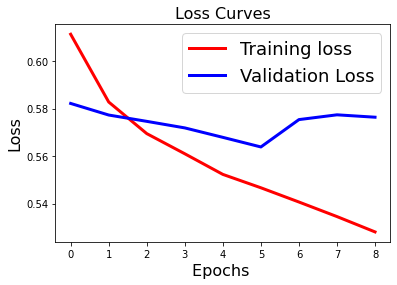

In [17]:
plt.figure(figsize=[6,4])
plt.plot(history_custom.history['loss'],'r',linewidth=3.0)
plt.plot(history_custom.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Summary of hyperparameters used

Below is a description of the hyperparameters used in the provided code and the reasons behind their choices:

1. Conv2D layer filters (32 and 64): The number of filters determines the depth or the number of channels in the output feature maps. In this case, 32 filters are chosen for the first Conv2D layer, and 64 filters are chosen for the second Conv2D layer. These values are typically selected based on the complexity of the problem and the size of the dataset. Higher values can capture more complex features but also increase computational requirements.

2. Kernel size (3, 3): The kernel size specifies the spatial extent of the convolutional window. A (3, 3) kernel scans a 3x3 window over the input image. Smaller kernel sizes focus on capturing local details, while larger kernel sizes capture more global features. The choice of (3, 3) is a common practice that balances capturing local and global features efficiently.

3. Activation function 'relu': The Rectified Linear Unit (ReLU) activation function is chosen for the Conv2D and Dense layers. ReLU introduces non-linearity to the model and has been proven effective in deep learning models. It helps to alleviate the vanishing gradient problem, allowing the network to learn more complex representations.

4. BatchNormalization: Batch normalization is applied after the first Conv2D layer. It normalizes the activations within each batch, reducing internal covariate shift and improving the training process. It helps to stabilize and accelerate the training by reducing the dependency on the scale of the activation values.

5. MaxPooling2D layer pool size (2, 2): Max pooling is used to downsample the spatial dimensions of the input. A pool size of (2, 2) means that the input is divided into non-overlapping 2x2 windows, and the maximum value within each window is selected. This downsampling operation helps in capturing the most dominant features while reducing the computational complexity.

6. Dropout rates (0.25 and 0.5): Dropout is used after the first Conv2D layer and the first Dense layer with dropout rates of 0.25 and 0.5, respectively. Dropout is a regularization technique that randomly sets a fraction of the input units to 0 during training. It helps to prevent overfitting by reducing the reliance on specific neurons and encourages the network to learn more robust features.

7. Dense layer units (128 and 1): The number of units in the Dense layers determines the dimensionality of the output space. In this case, 128 units are chosen for the first Dense layer, and 1 unit is chosen for the final Dense layer. The value of 128 is often selected based on the complexity of the problem and the number of trainable parameters. The final Dense layer with 1 unit is suitable for binary classification, where the output represents the probability of belonging to the positive class.

In summary, these hyperparameters are chosen based on best practices and empirical evidence in deep learning. The specific choices depend on the problem at hand, the available data, and the desired trade-off between model complexity and computational efficiency.

In [18]:
del model_custom ## Deleting the model variable to save memory

## Model 2 - Transfer learning

### Summary of Model Architecture

Apologies for the confusion. Here's a summary of the model architecture:

1. Base Model: ResNet101
   - The base model is ResNet101, a popular convolutional neural network architecture known for its deep structure and residual connections.
   - The weights of the model are initialized using pre-trained weights from the ImageNet dataset.
   - The top layer (classification layer) is excluded from the model using the `include_top=False` argument.

2. Freezing Layers:
   - The first 234 layers of the ResNet101 model are frozen, which means their weights are not updated during training.
   - By setting `layer.trainable = False` for these layers, their parameters are fixed.

3. Custom Layers:
   - The output of the base model is passed to additional layers to perform fine-tuning and adapt the model to a specific task.
   - Flatten layer: Flattens the output from the base model into a 1-dimensional vector.
   - Dense layer: Adds a fully connected layer with 1024 units and ReLU activation function.
   - Batch Normalization layer: Normalizes the activations of the previous layer to stabilize training.
   - Dropout layer: Randomly sets a fraction of input units to 0 during training to prevent overfitting.
   - Final Dense layer: Outputs the predictions with the number of units equal to the number of classes in the target task, using a softmax activation function.

4. Final Model:
   - The final model is created by specifying the input as the input of the base model and the output as the output of the custom layers.
   - `model_final = Model(model2.input, predictions)` binds the input and output layers together to form the complete model architecture.

This architecture allows you to leverage the pre-trained ResNet101 model while adding custom layers on top to adapt it to a specific classification task.

### Training and saving model

In [19]:
def tl_model_1(input_shape):
    model2 = applications.ResNet101(weights = "imagenet", include_top=False, input_shape = input_shape)
    for layer in model2.layers[:234]:
        layer.trainable = False
    
    #Adding custom Layers 
    x = model2.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation="sigmoid")(x)

    # creating the final model 
    model_final = Model(model2.input, predictions)
       
    return model_final

In [20]:
model_tl = tl_model_1(input_shape)
model_tl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 224, 184, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 109, 89, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 109, 89, 64)  256         ['conv1_conv[0][0]']         

In [21]:
model_tl.compile(loss=BinaryCrossentropy(from_logits=False),
              optimizer=Adadelta(),
              metrics=['accuracy', \
                       tensorflow.keras.metrics.AUC(), \
                       tfa.metrics.F1Score(num_classes=num_classes)])

In [22]:
history_tl = model_tl.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)

Epoch 1/100
1875/1875 [==============================] - 193s 91ms/step - loss: 0.9615 - accuracy: 0.5543 - auc_1: 0.5906 - f1_score: 0.4369 - val_loss: 0.8139 - val_accuracy: 0.5861 - val_auc_1: 0.6602 - val_f1_score: 0.4477
Epoch 2/100
1875/1875 [==============================] - 177s 94ms/step - loss: 0.8626 - accuracy: 0.5976 - auc_1: 0.6531 - f1_score: 0.4369 - val_loss: 0.8223 - val_accuracy: 0.5948 - val_auc_1: 0.6748 - val_f1_score: 0.4477
Epoch 3/100
1875/1875 [==============================] - 175s 93ms/step - loss: 0.7846 - accuracy: 0.6365 - auc_1: 0.7006 - f1_score: 0.4369 - val_loss: 0.7773 - val_accuracy: 0.6194 - val_auc_1: 0.6783 - val_f1_score: 0.4477
Epoch 4/100
1875/1875 [==============================] - 174s 93ms/step - loss: 0.7303 - accuracy: 0.6578 - auc_1: 0.7287 - f1_score: 0.4369 - val_loss: 0.7899 - val_accuracy: 0.6299 - val_auc_1: 0.6866 - val_f1_score: 0.4477
Epoch 5/100
1875/1875 [==============================] - 177s 94ms/step - loss: 0.6821 - accurac

In [24]:
#Create a directory named saved models and then run this cell
model_name = "saved_models/Transfer_Learning_ResNet_" + classification_attribute + ".h5"
model_tl.save(model_name) ## Saving the model

### Model performance

In [25]:
score = model_tl.evaluate(x_test, y_test, verbose=0)

In [26]:
print("Testing loss: ", score[0])
print("Testing accuracy: ", score[1])
print("Testing AUC: ", score[2])
print("Testing F1 score: ", score[3])

Testing loss:  0.8016496300697327
Testing accuracy:  0.6316499710083008
Testing AUC:  0.6930102109909058
Testing F1 score:  [0.4477473]


#### Plot of training vs validation loss

Text(0.5, 1.0, 'Loss Curves')

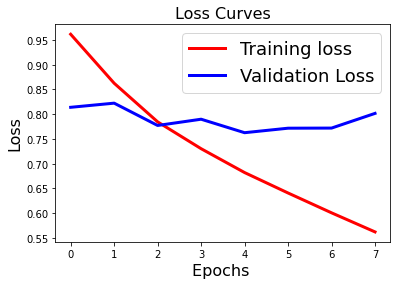

In [27]:
plt.figure(figsize=[6,4])
plt.plot(history_tl.history['loss'],'r',linewidth=3.0)
plt.plot(history_tl.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Summary of hyperparameters:

Below is a brief summary of the hyperparameters used in the code and their purposes:

1. Number of Layers frozen:
   - The first 234 layers of the ResNet101 model are frozen by setting `layer.trainable = False`.
   - This is done to prevent updating the weights of these layers during training.
   - Freezing the early layers is a common practice when fine-tuning pre-trained models, as it helps to retain the knowledge learned from the ImageNet dataset while focusing on adapting the later layers to the specific task.

2. Custom Layers:
   - Dense layer: The number of units in this layer is set to 1024 with a ReLU activation function. This choice depends on the complexity of the target task and the desired capacity of the model to learn high-level representations.
   - The activation function: The ReLU (Rectified Linear Unit) activation function is a common choice for introducing non-linearity in neural networks. It helps the model learn complex relationships between the input and the output by mapping negative values to zero and leaving positive values unchanged. ReLU has been shown to work well in many deep learning architectures. It is also very easy to compute the gradients for ReLU functions.
   - Batch Normalization layer: This layer normalizes the activations of the previous layer, which helps stabilize the training process by reducing internal covariate shift.
   - Dropout layer: Dropout with a rate of 0.5 is applied after the Dense layer to randomly set a fraction of input units to 0 during training. This regularizes the model and reduces the risk of overfitting.
   - Final Dense layer activation function: The softmax activation function is used to produce class probabilities. This is usual for multi

The specific values chosen for these hyperparameters can vary based on the dataset, the complexity of the task, and the available computational resources. The selection is often based on empirical experimentation and tuning to achieve optimal performance and balance between model capacity and overfitting.

## Model 3 - Transfer learning

### Model Architecture Summary

Here, the model architecture based on the VGG16 convolutional neural network, with some modifications and additional layers is contructed to implement transfer learning. Here is a summary of the architecture:

1. Pretrained Base Model:
   The base model is VGG16, which is initialized with pre-trained weights from the "imagenet" dataset. The `include_top=False` argument excludes the fully connected layers at the top of the network.
   
2. Freezing Layers:
   The code loops through the layers of the base model (`model2`) and freezes the first 205 layers by setting their `trainable` attribute to `False`. This means those layers' weights will not be updated during training.

3. Custom Layers:
   The output of the base model is passed through additional layers to customize the model. Here are the custom layers added:
   - Flatten: Flattens the tensor output from the base model to a 1-dimensional vector.
   - Dense(1024, activation="relu"): A fully connected layer with 1024 units and ReLU activation function.
   - BatchNormalization: Normalizes the activations of the previous layer, reducing internal covariate shift.
   - Dropout(0.5): Applies dropout regularization with a rate of 0.5, randomly setting 50% of the input units to 0 during training.
   - Dense(256, activation="relu"): Another fully connected layer with 256 units and ReLU activation function.
   - BatchNormalization
   - Dropout(0.5)

4. Final Layers:
   The output of the last dropout layer is fed into a dense layer with a number of units equal to the `num_classes` variable. The activation function used is sigmoid, indicating a multi-label classification problem.

5. Final Model:
   The `model_final` is created by specifying the inputs as the input of the `model2` and the outputs as the predictions from the last sigmoid dense layer.

In summary, the code creates a modified VGG16 model by freezing the first 205 layers, adding custom layers for further feature extraction and classification, and generating the final model for the specific task at hand.

### Training and saving model

In [28]:
def tl_model_2(input_shape):
    model2 = applications.VGG16(weights = "imagenet", include_top=False, input_shape = input_shape)
    for layer in model2.layers[:205]:
        layer.trainable = False
    
    #Adding custom Layers 
    x = model2.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation="sigmoid")(x)

    # creating the final model 
    model_final = Model(model2.input, predictions)
       
    return model_final

In [29]:
model_tl_2 = tl_model_2(input_shape)
model_tl_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0   

In [30]:
model_tl_2.compile(loss=BinaryCrossentropy(from_logits=False),
              optimizer=Adadelta(),
              metrics=['accuracy', \
                       tensorflow.keras.metrics.AUC(), \
                       tfa.metrics.F1Score(num_classes=num_classes)])

In [31]:
history_tl_2 = model_tl_2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)

Epoch 1/100
1875/1875 [==============================] - 66s 34ms/step - loss: 1.0419 - accuracy: 0.5057 - auc_2: 0.5063 - f1_score: 0.4369 - val_loss: 0.6904 - val_accuracy: 0.6147 - val_auc_2: 0.5726 - val_f1_score: 0.4477
Epoch 2/100
1875/1875 [==============================] - 60s 32ms/step - loss: 0.9925 - accuracy: 0.5300 - auc_2: 0.5397 - f1_score: 0.4369 - val_loss: 0.6686 - val_accuracy: 0.6305 - val_auc_2: 0.6124 - val_f1_score: 0.4477
Epoch 3/100
1875/1875 [==============================] - 61s 33ms/step - loss: 0.9589 - accuracy: 0.5491 - auc_2: 0.5670 - f1_score: 0.4369 - val_loss: 0.6518 - val_accuracy: 0.6439 - val_auc_2: 0.6307 - val_f1_score: 0.4477
Epoch 4/100
1875/1875 [==============================] - 61s 33ms/step - loss: 0.9339 - accuracy: 0.5546 - auc_2: 0.5755 - f1_score: 0.4369 - val_loss: 0.6430 - val_accuracy: 0.6511 - val_auc_2: 0.6443 - val_f1_score: 0.4477
Epoch 5/100
1875/1875 [==============================] - 60s 32ms/step - loss: 0.9178 - accuracy: 0.

In [36]:
#Create a directory named saved models and then run this cell
model_name = "saved_models/Transfer_Learning_VGG16_" + classification_attribute + ".h5"
model_tl_2.save(model_name) ## Saving the model

### Model Performance

In [37]:
score = model_tl_2.evaluate(x_test, y_test, verbose=0)

In [38]:
print("Testing loss: ", score[0])
print("Testing accuracy: ", score[1])
print("Testing AUC: ", score[2])
print("Testing F1 score: ", score[3])

Testing loss:  0.5612890720367432
Testing accuracy:  0.7336999773979187
Testing AUC:  0.7065133452415466
Testing F1 score:  [0.4477473]


#### Plot of training vs validation loss

Text(0.5, 1.0, 'Loss Curves')

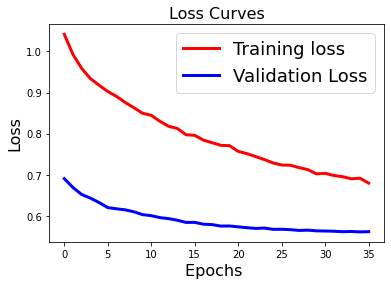

In [39]:
plt.figure(figsize=[6,4])
plt.plot(history_tl_2.history['loss'],'r',linewidth=3.0)
plt.plot(history_tl_2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

### Summary of hyperparameters

The provided code snippet does not explicitly define any hyperparameters. However, I can provide a summary of the notable hyperparameters that can be inferred from the code:

1. The number of frozen layers:
   This code snippet freezes the first 205 layers of the VGG16 base model by setting their `trainable` attribute to `False`. Freezing layers is a way to control the training of specific layers and can be considered as a form of hyperparameter in terms of network training. By minimising the number of trainable layers, we reduce the computational cost. However, the trade off is that the accuracy will be lesser.

2. Number of Dense layers:
   The `Dense` layer added after the flattening operation has 1024 units. The choice of the number of units in this layer can be considered a hyperparameter. The activation function used in this layer is ReLU (Rectified Linear Unit).
   
3. Activation Function:
    The ReLU (Rectified Linear Unit) activation function is a common choice for introducing non-linearity in neural networks. It helps the model learn complex relationships between the input and the output by mapping negative values to zero and leaving positive values unchanged. ReLU has been shown to work well in many deep learning architectures. It is also very easy to compute the gradients for ReLU functions.
   
4. Batch Normalization: 
    Batch normalization is a technique used to normalize the activations of a neural network layer, aiming to stabilize and speed up the training process. It helps mitigate the internal covariate shift by normalizing the mean and variance of each batch's input. Batch normalization can improve the model's ability to generalize and can also act as a regularizer, reducing the reliance on dropout or weight decay.

5. Dropout: 
    Dropout is a regularization technique that randomly sets a fraction of input units to zero during training. By doing so, dropout prevents units from relying too heavily on other specific units and encourages the network to learn more robust and generalizable representations. In this case, a dropout rate of 0.5 is applied, meaning that 50% of the units in the previous dense layer will be randomly set to zero during training.

6. Output Layer: 
    The output layer is a dense layer with the number of units equal to the number of classes in the dataset (102). The softmax activation function is used to compute probabilities for each class, allowing the model to provide a probability distribution over the classes and make predictions based on the highest probability.